Tutorial 5: Chaining Phases
==========================

So, we've learnt that if our parameter space is too complex, our `NonLinearSearch` might fail to find the global
maximum solution. However, we also learnt how to ensure this doesn`t happen, by:

 1) Tuning our priors to the strong lens we're fitting.
 2) Making our lens model less complex.
 3) Searching non-linear parameter space for longer.

However, each of the above approaches has disadvantages. The more we tune our priors, the less we can generalize our
analysis to a different strong lens. The less complex we make our model, the less realistic it is. And if we rely too
much on searching parameter space for longer, we could end up with phase`s that take days, weeks or months to run.

In this exercise, we're going to combine these 3 approaches so that we can fit complex and realistic lens models in a
way that that can be generalized to many different strong lenses. To do this, we'll run 2 phases, and chain the lens
model inferred in the first phase to the priors of the second phase`s lens model.

Our first phase will make the same light-traces-mass assumption we made in the previous tutorial. We saw that this
gives a reasonable lens model. However, we'll make a couple of extra simplifying assumptions, to really try and bring
our lens model complexity down and get the `NonLinearSearch` running fast.

The model we infer above will therefore be a lot less realistic. But it doesn`t matter, because in the second phase
we're going to relax these assumptions and get back our more realistic lens model. The beauty is that, by running the
first phase, we can use its results to tune the priors of our second phase. For example:

 1) The first phase should give us a pretty good idea of the lens galaxy's light and mass profiles, for example its
 intensity, effective radius and einstein radius.

 2) It should also give us a pretty good fit to the lensed source galaxy. This means we'll already know where in
 source-plane its is located and what its intensity and effective are.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's `LightProfile` is an `EllipticalSersic`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we'll create and use a smaller 2.0" `Mask2D` again.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

When plotted, the lens light`s is clearly visible in the centre of the image.

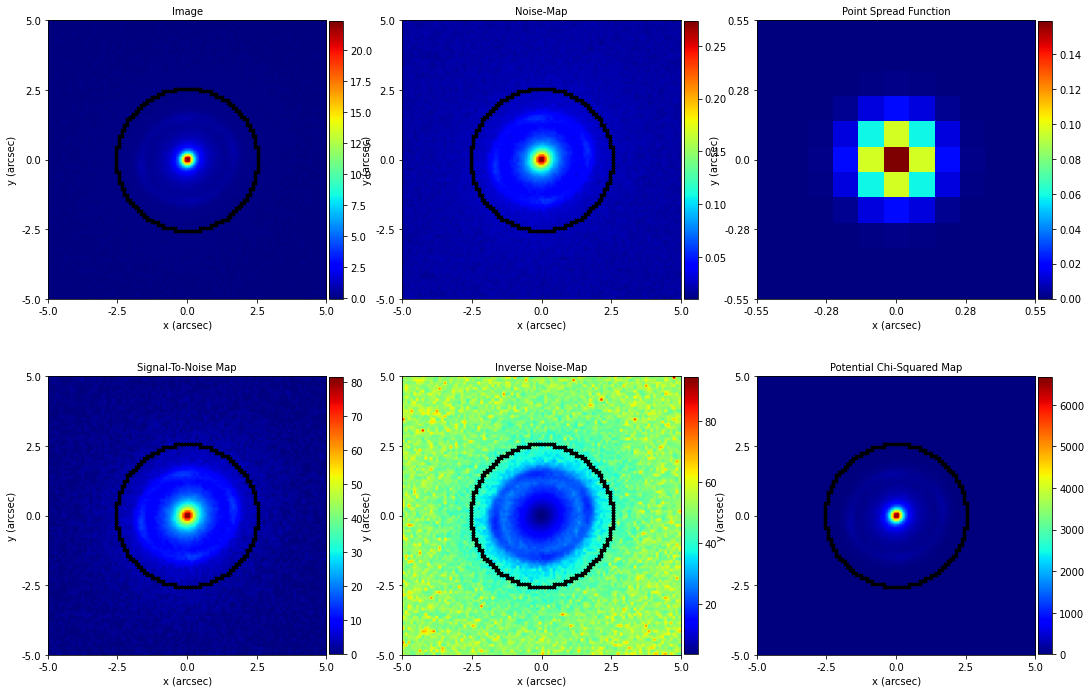

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Like in the previous tutorial, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

As we've eluded to before, one can look at an image and immediately identify the centre of the lens galaxy. It's 
that bright blob of light in the middle! Given that we know we're going to make the lens model more complex in the 
next phase, lets take a more liberal approach than before and fix the lens centre to $(y,x)$ = (0.0", 0.0").

In [6]:
lens = al.GalaxyModel(
    redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential)

You haven't actually seen a line like this one before. By setting a parameter to a number (and not a prior) it is be 
removed from non-linear parameter space and always fixed to that value. Pretty neat, huh?

In [7]:
lens.bulge.centre_0 = 0.0
lens.bulge.centre_1 = 0.0
lens.mass.centre_0 = 0.0
lens.mass.centre_1 = 0.0

Lets use the same approach of making the ellipticity of the mass trace that of the sersic.

In [8]:
lens.mass.elliptical_comps = lens.bulge.elliptical_comps

Now, you might be thinking, doesn`t this prevent our phase from generalizing to other strong lenses? What if the 
centre of their lens galaxy isn't at (0.0", 0.0")?

Well, this is true if our dataset reduction centres the lens galaxy somewhere else. But we get to choose where we 
centre it when we make the image. Therefore, I`d recommend you always centre the lens galaxy at the same location, 
and (0.0", 0.0") seems the best choice!

We also discussed that the Sersic index of most lens galaxies is around 4. Lets fix it to 4 this time.

In [9]:
lens.bulge.sersic_index = 4.0

Now lets create the phase.

In [10]:
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t5_chaining_phases_1", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
)

Lets run the phase, noting that our liberal approach to reducing the lens model complexity has reduced it to just 
11 parameters. (The results are still preloaded for you, but feel free to run it yourself, its fairly quick).

In [11]:
print(
    "Dynesty has begun running - checkout the workspace/output/5_chaining_phases"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

phase1_result = phase1.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output/5_chaining_phases folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:phase_t5_chaining_phases_1 already completed, skipping non-linear search.


Dynesty has finished run - you may now continue the notebook.


And indeed, we get a reasonably good model and fit to the data - in a much shorter space of time!

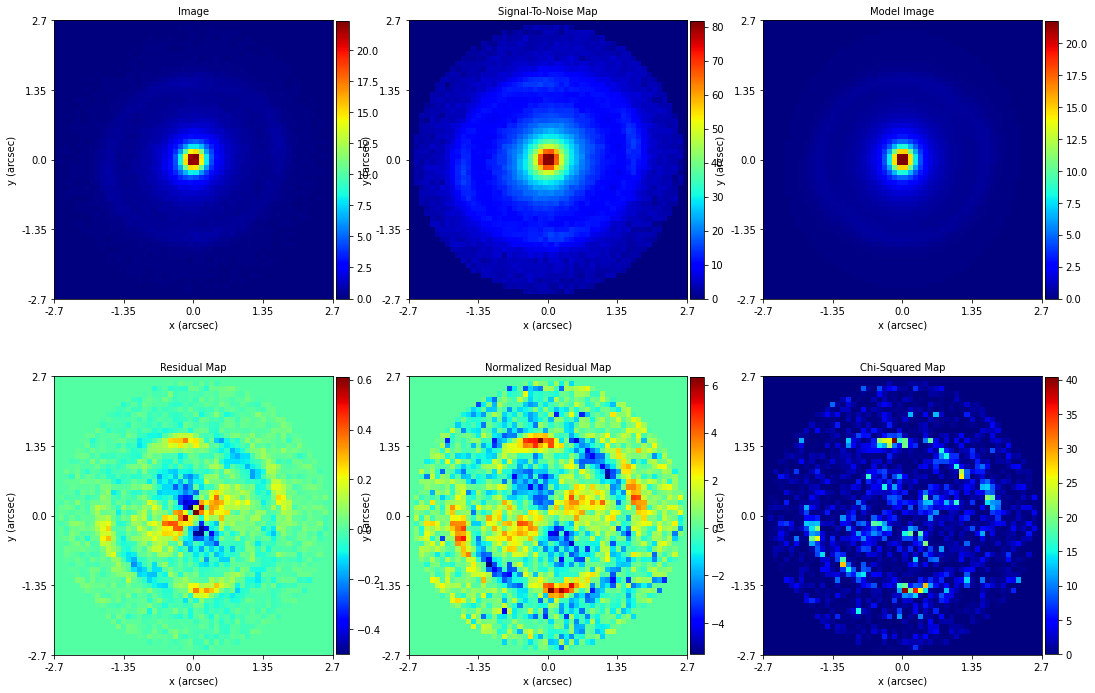

In [12]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Now all we need to do is look at the results of phase 1 and tune our priors in phase 2 to those result. Lets setup 
a custom phase that does exactly that.

GaussianPriors are a nice way to do this. They tell the `NonLinearSearch` where to look, but leave open the 
possibility that there might be a better solution nearby. In contrast, UniformPriors put hard limits on what values a 
parameter can or can`t take. It makes it more likely we'll accidently cut-out the global maxima solution.

In [13]:
lens = al.GalaxyModel(
    redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalExponential)

What I've done below is looked at the results of phase 1 and manually specified a prior for every parameter. If a 
parameter was fixed in the previous phase, its prior is based around the previous value. Don't worry about the sigma 
values for now, I've chosen values that I know will ensure reasonable sampling, but we'll cover this later.

__LENS LIGHT PRIORS:__

In [14]:
lens.bulge.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
lens.bulge.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
lens.bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.33333, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
lens.bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
lens.bulge.intensity = af.GaussianPrior(
    mean=1.1, sigma=0.01, lower_limit=0.0, upper_limit=np.inf
)
lens.bulge.effective_radius = af.GaussianPrior(
    mean=0.72, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)
lens.bulge.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=2.0, lower_limit=0.0, upper_limit=np.inf
)

__LENS MASS PRIORS:__

In [15]:
lens.mass.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
lens.mass.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
lens.mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.33333, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
lens.mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
lens.mass.einstein_radius = af.GaussianPrior(
    mean=1.6, sigma=0.1, lower_limit=0.0, upper_limit=np.inf
)

__SOURCE LIGHT PRIORS:__

In [16]:
source.bulge.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
source.bulge.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
source.bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.43, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
source.bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.23, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
source.bulge.intensity = af.GaussianPrior(
    mean=0.17, sigma=0.05, lower_limit=0.0, upper_limit=np.inf
)
source.bulge.effective_radius = af.GaussianPrior(
    mean=0.14, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)

Lets setup and run the phase. As expected, it gives us the correct lens model. However, it does so significantly faster 
than we're used to, I didn't have to edit the config files to get this phase to run fast!

In [17]:
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t5_chaining_phases_2", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
)

print(
    "Dynesty has begun running - checkout the workspace/output/5_chaining_phases"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

phase2_result = phase2.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:phase_t5_chaining_phases_2 already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/5_chaining_phases folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


Look at that, the right lens model, again!

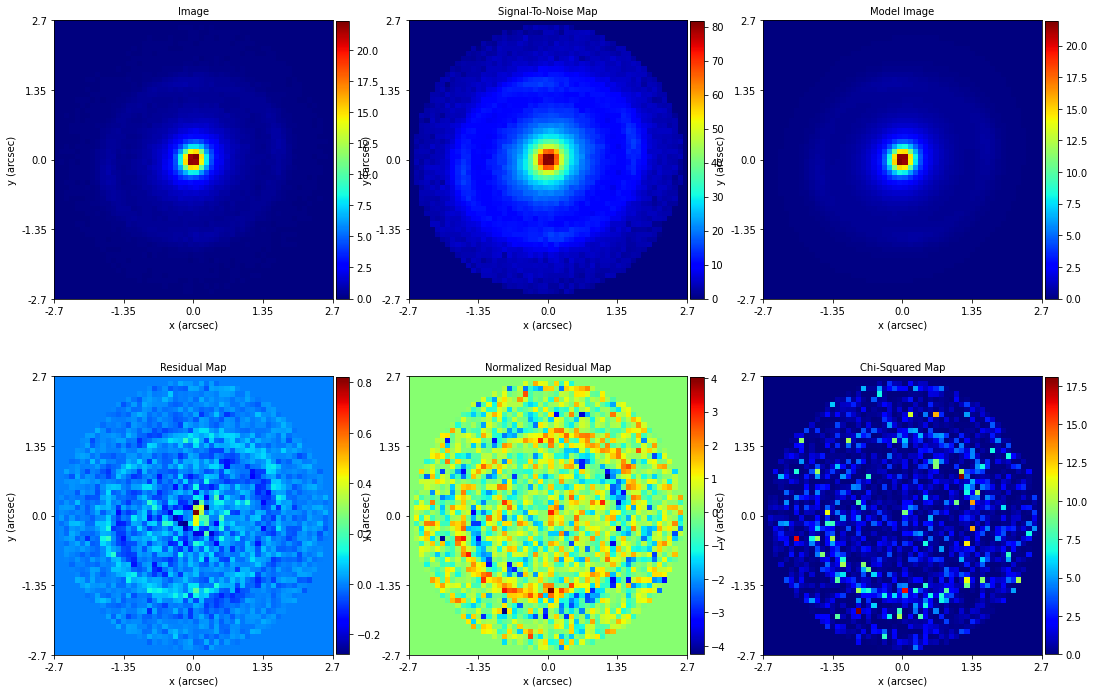

In [18]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Our choice to chain two phases together was a huge success. We managed to fit a complex and realistic model, but were 
able to begin by making simplifying assumptions that eased our search of non-linear parameter space. We could apply 
phase 1 to pretty much any strong lens and therefore get ourselves a decent lens model with which to tune phase 2`s 
priors.

You`re probably thinking though that there is one huge, giant, glaring flaw in all of this that I've not mentioned. 
Phase 2 can`t be generalized to another lens - it`s priors are tuned to the image we fitted. If we had a lot of lenses, 
we`d have to write a new phase2 for every single one. This isn't ideal, is it?

Fortunately, we can pass priors in **PyAutoLens** without specifying the specific values, using what we call promises. 
The code below sets up phase2 with priors fully chained, but without specifying each individual prior!

In [19]:
phase2_pass = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens",
        name="phase_t5_chaining_phases_2_pass",
        n_live_points=40,
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=phase1_result.model.galaxies.lens,
        source=phase1_result.model.galaxies.source,
    ),
)

phase2_pass.run(dataset=imaging, mask=mask)

INFO:root:phase_t5_chaining_phases_2_pass already completed, skipping non-linear search.


By using the following API to chain the result to the next model:
 
 lens = phase1_result.model.galaxies.lens
 source = phase1_result.model.galaxies.source
 
Once the above phase is running, you should checkout its `model.info` file. The parameters do not use the default 
priors we saw in phase 1 (which are typically broad UniformPriors). Instead, it uses GaussianPrior`s where:

 - The mean values are the median PDF results of every parameter in phase 1.
 - Many sigma values are the errors computed at 3.0 sigma confidence of every parameter in phase 1.
 - Other sigma values are higher than the errors computed at 3.0 sigma confidence. These instead use the value 
 specified in the `width_modifier` field of the `Profile`'s entry in the `json_config` files (we will discuss
 why this is used in a moment).

Thus, much like the manual GaussianPriors I specified above, we have set up the phase with GaussianPriors centred on
the high likelihood regions of parameter space!
 
The priors passed above retained the model parameterization of phase 1, including the fixed values of (0.0, 0.0) for
the centres of the light and mass profiles and the alignment between their elliptical components. However, we often 
want to pass priors *and* change the model parameterization.

To do this, we have to use the `PriorModel` object in AutoFit, which allows us to turn light and mass profiles into 
`model components` whose parameters have priors that can be manipulated in an analogous fashion to to `GalaxyModel`.
In fact, the individual components of the `GalaxyModel` class have been `PriorModel`'s all along! 

In [20]:
print(lens.bulge)
print(lens.mass)
print(source.bulge)

EllipticalSersic (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (elliptical_comps_0, GaussianPrior, mean = 0.33333, sigma = 0.15), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.2), (intensity, GaussianPrior, mean = 1.1, sigma = 0.01), (effective_radius, GaussianPrior, mean = 0.72, sigma = 0.2), (sersic_index, GaussianPrior, mean = 4.0, sigma = 2.0)
EllipticalIsothermal (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (elliptical_comps_0, GaussianPrior, mean = 0.33333, sigma = 0.15), (elliptical_comps_1, GaussianPrior, mean = 0.0, sigma = 0.2), (einstein_radius, GaussianPrior, mean = 1.6, sigma = 0.1)
EllipticalExponential (centre_0, GaussianPrior, mean = 0.0, sigma = 0.1), (centre_1, GaussianPrior, mean = 0.0, sigma = 0.1), (elliptical_comps_0, GaussianPrior, mean = 0.43, sigma = 0.15), (elliptical_comps_1, GaussianPrior, mean = 0.23, sigma = 0.2), (intensity, Gau

We can thus set up the `GalaxyModel`  we desire, by first creating the individual `PriorModel`'s of each
component and then passing the priors of each individual parameter. 

__LENS LIGHT PRIORS:__

In [21]:
sersic = af.PriorModel(al.lp.EllipticalSersic)

sersic.elliptical_comps.elliptical_comps = (
    phase1_result.model.galaxies.lens.bulge.elliptical_comps
)
sersic.intensity = phase1_result.model.galaxies.lens.bulge.intensity
sersic.effective_radius = phase1_result.model.galaxies.lens.bulge.effective_radius

__LENS MASS PRIORS:__

In [22]:
mass = af.PriorModel(al.mp.EllipticalIsothermal)

lens.mass.elliptical_comps.elliptical_comps = (
    phase1_result.model.galaxies.lens.mass.elliptical_comps
)
lens.mass.einstein_radius = phase1_result.model.galaxies.lens.mass.einstein_radius

lens = al.GalaxyModel(redshift=0.5, bulge=sersic, mass=mass)

We now create and run the phase, using the lens `GalaxyModel` we created above.

In [23]:
phase2_pass = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens",
        name="phase_t5_chaining_phases_2_pass_individual",
        n_live_points=40,
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens=lens, source=phase1_result.model.galaxies.source
    ),
)

phase2_pass.run(dataset=imaging, mask=mask)

INFO:root:phase_t5_chaining_phases_2_pass_individual already completed, skipping non-linear search.


Don't worry too much about whether you fully understand the prior passing API yet, as this will be a key subject in
chapter 3 when we consider pipelines. Furthermore, in the `autolens_workspace/pipelines` directly you'll find
numerous example pipelines that give examples of how to perform prior passing for many common lens models. 

To end, lets consider how we passed priors using the `model` attribute of the phase 1 results above, as its not clear 
how priors are passed. Do they use a UniformPrior or GaussianPrior? What are the limits / mean / width of 
these priors?

Lets say I chain two parameters as follows:
 
 ```
 mass.einstein_radius = phase1_result.model.galaxies.lens.mass.einstein_radius
```

By invoking the `model` attribute, the prioris passed following 3 rules:

 1) The new parameter, in this case the einstein radius, uses a GaussianPrior. A GaussianPrior is ideal, as the 1D 
 pdf results we compute at the end of a phase are easily summarized as a Gaussian.

 2) The mean of the GaussianPrior is the median PDF value of the parameter estimated in phase 1.
    
 This ensures that the initial sampling of the new phase's non-linear starts by searching the region of non-linear 
 parameter space that correspond to highest log likelihood solutions in the previous phase. Thus, we're setting 
 our priors to look in the `correct` regions of parameter space.

 3) The sigma of the Gaussian will use the maximum of two values: 
   
 (i) the 1D error of the parameter computed at an input sigma value (default sigma=3.0).
 
 (ii) The value specified for the profile in the `config/priors/*.json` config file's `width_modifer` 
 field (check these files out now).

 The idea here is simple. We want a value of sigma that gives a GaussianPrior wide enough to search a broad 
 region of parameter space, so that the lens model can change if a better solution is nearby. However, we want it 
 to be narrow enough that we don't search too much of parameter space, as this will be slow or risk leading us 
 into an incorrect solution! A natural choice is the errors of the parameter from the previous phase.
       
 Unfortunately, this doesn't always work. Lens modeling is prone to an effect called `over-fitting` where we 
 underestimate the errors on our lens model parameters. This is especially true when we take the shortcuts in 
 early phases - fast `NonLinearSearch` settings, simplified lens models, etc.
    
 Therefore, the `width_modifier` in the json config files are our fallback. If the error on a parameter is 
 suspiciously small, we instead use the value specified in the widths file. These values are chosen based on 
 our experience as being a good balance broadly sampling parameter space but not being so narrow important solutions 
 are missed. 
       
There are two ways a value is specified using the priors/width file:

 1) Absolute: In this case, the error assumed on the parameter is the value given in the config file. 
 For example, if for the width on centre_0 of a `LightProfile`, the width modifier reads "Absolute" with a value 
 0.05. This means if the error on the parameter centre_0 was less than 0.05 in the previous phase, the sigma of 
 its GaussianPrior in this phase will be 0.05.
    
 2) Relative: In this case, the error assumed on the parameter is the % of the value of the 
 estimate value given in the config file. For example, if the intensity estimated in the previous phase was 2.0, 
 and the relative error in the config file reads "Relative" with a value 0.5, then the sigma of the GaussianPrior 
 will be 50% of this value, i.e. sigma = 0.5 * 2.0 = 1.0.

We use absolute and relative values for different parameters, depending on their properties. For example, using the 
relative value of a parameter like the `Profile` centre makes no sense. If our lens galaxy is centred at (0.0, 0.0), 
the relative error will always be tiny and thus poorly defined. Therefore, the default configs in **PyAutoLens** use 
absolute errors on the centre.

However, there are parameters where using an absolute value does not make sense. Intensity is a good example of this. 
The intensity of an image depends on its unit_label, S/N, galaxy brightness, etc. There is no single absolute value 
that one can use to generically chain the intensity of any two proflies. Thus, it makes more sense to chain them using 
the relative value from a previous phase.

We can customize how priors are passed from the results of a phase and `NonLinearSearch` by inputting to the search 
a PriorPasser object:

```
search = af.DynestyStatic(
    prior_passer=af.PriorPasser(sigma=2.0, use_widths=False, use_errors=True)
)
```

The PriorPasser allows us to customize at what sigma the error values the model results are computed at to compute
the passed sigma values and customizes whether the widths in the config file, these computed errors, or both, 
are used to set the sigma values of the passed priors.

The default values of the PriorPasser are found in the config file of every non-linear search, in the [prior_passer]
section. All non-linear searches by default use a sigma value of 3.0, use_width=True and use_errors=True. We anticipate
you should not need to change these values to get lens modeling to work proficiently!

__EXAMPLE__

Lets go through an example using a real parameter. Lets say in phase 1 we fit the lens galaxy's light with an 
elliptical Sersic profile, and we estimate that its sersic index is equal to 4.0 ± 2.0 where the error value of 2.0 
was computed at 3.0 sigma confidence. To pass this as a prior to phase 2, we would write:

 lens.bulge.sersic_index = phase1.result.model.lens.bulge.sersic_index

The prior on the lens galaxy's sersic `LightProfile` in phase 2 would thus be a GaussianPrior, with mean=4.0 and 
sigma=2.0. If we had used a sigma value of 1.0 to compute the error, which reduced the estimate from 4.0 ± 2.0 to 
4.0 ± 1.0, the sigma of the Gaussian prior would instead be 1.0. 

If the error on the Sersic index in phase 1 had been really small, lets say, 0.01, we would instead use the value of the 
Sersic index width in the priors config file to set sigma instead. In this case, the prior config file specifies 
that we use an "Absolute" value of 0.8 to chain this prior. Thus, the GaussianPrior in phase 2 would have a mean=4.0 and 
sigma=0.8.

If the prior config file had specified that we use an relative value of 0.8, the GaussianPrior in phase 2 would have a 
mean=4.0 and sigma=3.2.

And with that, we're done. Chaining priors is a bit of an art form, but one that tends to work really well. Its true to 
say that things can go wrong - maybe we `trim` out the solution we're looking for, or underestimate our errors a bit 
due to making our priors too narrow. However, in general, things are okay, and the example pipelines in 
`autolens_workspace/pipelines` have been thoroughly tested to ensure prior chaining works effectively.